In [1]:
import pickle
import numpy as np
import scqubits
from scqubits.core.discretization import Grid1d
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
from copy import deepcopy
from CoupledQuantumSystems.systems import TransmonOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

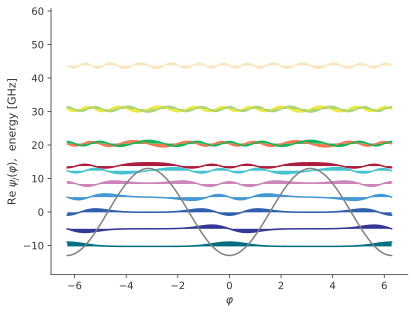

In [2]:
max_ql = 40
max_ol = 120
EJ = 13
EC = 0.3
ng = 0.0
ncut = 50
qbt = scqubits.Transmon(EJ=EJ, EC=EC, ng=ng,ncut=ncut,truncated_dim=max_ql)
qbt.plot_wavefunction(which = list(range(12)),
                      phi_grid=Grid1d(min_val=-2*np.pi,max_val=2*np.pi,pt_count=100),
                      scaling=0.5)

In [3]:
qbt.eigenvals(10)-qbt.eigenvals(10)[0]

array([ 0.        ,  5.26674561, 10.18371638, 14.71003604, 18.63892983,
       22.6007086 , 23.98831075, 30.62961774, 30.68015993, 41.00731365])

(<Figure size 640x480 with 2 Axes>, <Axes: >)

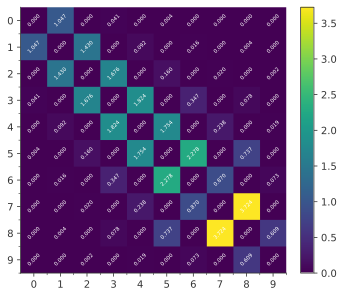

In [4]:
qbt.plot_matrixelements(operator='n_operator',
                        evals_count=10,
                        show3d=False,
                        show_numbers=True)

In [5]:
def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)

Er loop:   0%|          | 0/100 [00:00<?, ?it/s]RuntimeWarning: divide by zero encountered in scalar divide
 /tmp/ipykernel_66891/1747159573.py: 2RuntimeWarning: invalid value encountered in scalar subtract
Er loop: 100%|██████████| 100/100 [00:00<00:00, 85720.50it/s]

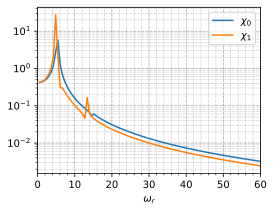

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

matrix = qbt.n_operator(energy_esys=True)
evals = qbt.eigenvals()
Er_list = np.linspace(0,60,100)
qls = [0,1]
ylim=(-2,2)
num_evals =len(evals)

for ql  in qls:
    shift_from_qubit_transition = []
    for Er in tqdm(Er_list, desc = "Er loop"):
        shifts = [get_shift_accurate(matrix[ql,ql2], evals[ql2], evals[ql], Er) for ql2 in range(num_evals)] 
        shift_from_qubit_transition.append(sum(shifts))
    shift_from_qubit_transition = np.abs(shift_from_qubit_transition)
    ax.plot(Er_list, shift_from_qubit_transition, label=rf'$\chi_{ql}$')

ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.set_xlim(Er_list[0],Er_list[-1])
# ax.set_ylim(ylim[0],ylim[1])
ax.set_xlabel(rf'$\omega_r$')
ax.set_yscale('log')
ax.legend()

In [7]:
g = 0.01
Er = 30
kappa = 0.01
system  =  TransmonOscillatorSystem(
                qbt = qbt,
                Er = Er,
                g_strength = g,
                kappa=kappa,
                max_ql = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(15) for ol in range(max_ol) ],
                )

In [11]:
id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_qbt_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
qbt_creation_arr = id_wrapped_qbt_destory.dag().full()
qbt_destory_arr= id_wrapped_qbt_destory.full()

ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)
with open('ladder_overlap.pkl', 'wb') as f:
    pickle.dump(ladder_overlap,f)
def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)] if system.product_to_dressed[(ql,ol)] is not None else -1
        
        if ol < 1:
            overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        else:
            overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

for ql in range(max_ql):
    for ol in range(max_ol):
        system.product_to_dressed[(ql,ol)] =  overlap_idx_arr[ql,ol] 


In [12]:

system.set_sign_multiplier()
system.set_new_product_to_keep([[ql, ol] for ql in range(15) for ol in range(max_ol) ])
system.set_new_operators_after_setting_new_product_to_keep()
with open('syste.pkl', 'wb') as f:
    pickle.dump(system,f)

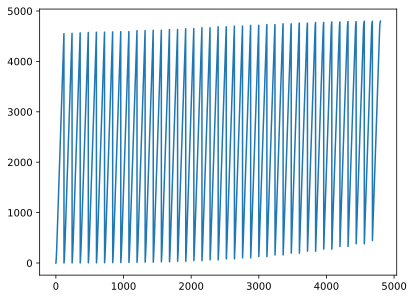

In [13]:
plt.plot(overlap_idx_arr.flatten())
# plt.ylim(0,100)

In [14]:
def get_photon_number(state):
    state_after_a = resonator_destory_arr @ state
    return np.abs(np.sum(state_after_a**2).real)
def get_qbt_number(state):
    state_after_a = qbt_destory_arr @ state
    return np.abs(np.sum(state_after_a**2).real)

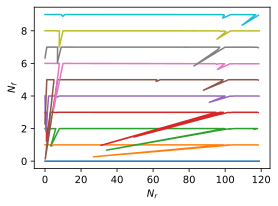

In [15]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
qls = list(range(max_ql))


for ql in list(range(10)):

    photon_num_arr = np.zeros((max_ol))
    qbt_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        photon_num_arr[ol] = get_photon_number(system.evecs[overlap_idx_arr[ql][ol]].full())
        qbt_num_arr[ol] = get_qbt_number(system.evecs[overlap_idx_arr[ql][ol]].full())

    ax.plot(photon_num_arr,qbt_num_arr,label=f'{ql}')

# ax.set_ylim(0,4)
# ax.set_xlim(0,max_ol-5)
ax.set_xlabel(r'$N_r$')
ax.set_ylabel(r'$N_f$')

plt.tight_layout()
fig.savefig('hybridization.pdf')

In [16]:
with open('syste.pkl', 'rb') as f:
    system = pickle.load(f)

In [17]:
system.evals[ system.product_to_dressed[(0,1)] ] - system.evals[ system.product_to_dressed[(0,0)] ], \
system.evals[ system.product_to_dressed[(1,1)] ] - system.evals[ system.product_to_dressed[(1,0)] ]

(30.000000665900046, 30.000000502781365)

In [13]:
state_leak_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(0,0)])
state_0_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(1,0)])
state_1_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(2,0)])
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                    state_leak_dressed,
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

leakage_products_to_keep = [[ql, ol] for ql in [0] for ol in range(max_ol) ]
computational_products_to_keep = [[ql, ol] for ql in [1,2] for ol in range(150) ]
list_of_products_to_keep = [
    leakage_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep
]


list_of_systems = []
list_of_kwargs = []
for products_to_keep, y0 in zip(list_of_products_to_keep, initial_states):
    system.set_new_product_to_keep(products_to_keep)
    system.set_new_operators_after_setting_new_product_to_keep()
    list_of_systems.append(deepcopy(system))
    list_of_kwargs.append( {
        'y0':system.truncate_function(y0) ,
        'tlist':tlist,
        'drive_terms':[DriveTerm( 
                            driven_op= system.driven_operator,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_shape_args={
                                'w_d': w_d ,
                                'amp': amp,
                                't_rise': 20,
                                't_square': tot_time
                            })],
        'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
        # 'c_ops':[kappa *qutip.lindblad_dissipator(system.a_trunc) ]
        })
    

results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
    list_of_systems,
    list_of_kwargs,
    post_processing = ['pad_back']
)

import pickle
with open('sesolve_small_dim_a015_tomo.pkl', 'wb') as file:
    pickle.dump(results, file)


 Total run time: 290.89s*] Elapsed 290.89s / Remaining 00:00:00:00 [*********43%           ] Elapsed 126.09s / Remaining 00:00:02:47
 [*********98%***********] Elapsed 290.96s / Remaining 00:00:00:05

Processing states with pad_back_custom:   7%|▋         | 29/400 [00:00<00:04, 79.35it/s]

 [*********99%***********] Elapsed 291.27s / Remaining 00:00:00:02

Processing states with pad_back_custom:  16%|█▌        | 63/400 [00:00<00:04, 78.21it/s]

 [********100%***********] Elapsed 291.76s / Remaining 00:00:00:00

Processing states with pad_back_custom:  20%|█▉        | 79/400 [00:01<00:04, 71.68it/s]

 [*********99%***********] Elapsed 292.04s / Remaining 00:00:00:02

Processing states with pad_back_custom:  24%|██▍       | 96/400 [00:01<00:04, 73.18it/s]

 [*********99%***********] Elapsed 292.41s / Remaining 00:00:00:02

Processing states with pad_back_custom:  28%|██▊       | 112/400 [00:01<00:04, 71.57it/s]

 Total run time: 292.50s*] Elapsed 292.50s / Remaining 00:00:00:00
 [*********98%***********] Elapsed 292.55s / Remaining 00:00:00:05

Processing states with pad_back_custom:   6%|▌         | 23/400 [00:00<00:05, 66.79it/s]]

 [*********99%***********] Elapsed 292.96s / Remaining 00:00:00:02

Processing states with pad_back_custom:  14%|█▍        | 55/400 [00:00<00:04, 73.72it/s]]

 [*********98%***********] Elapsed 293.32s / Remaining 00:00:00:05

Processing states with pad_back_custom:   0%|          | 0/400 [00:00<?, ?it/s]0.21it/s]]

 Total run time: 293.70s*] Elapsed 293.70s / Remaining 00:00:00:00
 [*********99%***********] Elapsed 293.80s / Remaining 00:00:00:02

Processing states with pad_back_custom:  57%|█████▋    | 229/400 [00:03<00:02, 73.66it/s]

 [*********99%***********] Elapsed 294.13s / Remaining 00:00:00:02

Processing states with pad_back_custom:  40%|███▉      | 158/400 [00:02<00:03, 72.28it/s]

 [********100%***********] Elapsed 294.76s / Remaining 00:00:00:00

Processing states with pad_back_custom:  47%|████▋     | 188/400 [00:02<00:03, 62.98it/s]

 [*********60%**         ] Elapsed 295.02s / Remaining 00:00:03:16

Processing states with pad_back_custom:  34%|███▍      | 136/400 [00:01<00:03, 69.52it/s]

 Total run time: 295.41s*] Elapsed 295.41s / Remaining 00:00:00:00


Processing states with pad_back_custom:   0%|          | 0/400 [00:00<?, ?it/s]73.40it/s]

 Total run time: 295.77s*] Elapsed 295.77s / Remaining 00:00:00:00
 [*********99%***********] Elapsed 295.89s / Remaining 00:00:00:02

Processing states with pad_back_custom:  67%|██████▋   | 269/400 [00:03<00:01, 73.55it/s]

 [*********60%**         ] Elapsed 296.18s / Remaining 00:00:03:17

Processing states with pad_back_custom:  80%|████████  | 321/400 [00:04<00:01, 78.14it/s]

 [********100%***********] Elapsed 296.70s / Remaining 00:00:00:00

Processing states with pad_back_custom:  66%|██████▋   | 266/400 [00:03<00:01, 74.67it/s]

 Total run time: 297.37s*] Elapsed 297.37s / Remaining 00:00:00:00


Processing states with pad_back_custom:  55%|█████▌    | 221/400 [00:02<00:02, 78.46it/s]

 [*********61%**         ] Elapsed 298.31s / Remaining 00:00:03:10

Processing states with pad_back_custom:  37%|███▋      | 149/400 [00:01<00:03, 80.27it/s]

 [*********61%**         ] Elapsed 299.25s / Remaining 00:00:03:11

Processing states with pad_back_custom:  56%|█████▌    | 222/400 [00:02<00:02, 82.13it/s]

 [*********61%**         ] Elapsed 300.12s / Remaining 00:00:03:11

Processing states with pad_back_custom:  74%|███████▎  | 294/400 [00:03<00:01, 81.72it/s]

 [*********62%**         ] Elapsed 301.03s / Remaining 00:00:03:04

Processing states with pad_back_custom:  92%|█████████▏| 366/400 [00:04<00:00, 87.38it/s]

 [*********62%**         ] Elapsed 301.88s / Remaining 00:00:03:05

Processing states with pad_back_custom: 100%|██████████| 400/400 [00:04<00:00, 82.21it/s]


 Total run time: 478.48s*] Elapsed 478.48s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 400/400 [00:04<00:00, 81.63it/s]


In [22]:
with open('sesolve_small_dim_a015_tomo.pkl', 'rb') as file:
    results = pickle.load(file)

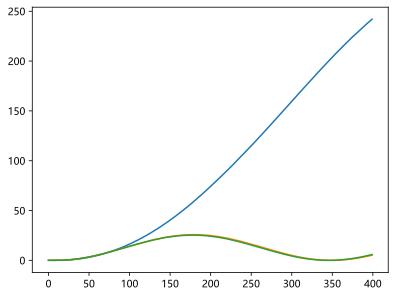

In [14]:
for i in [0,1,2]:
    plt.plot(results[i].expect[1])

(345.0, 350.0)

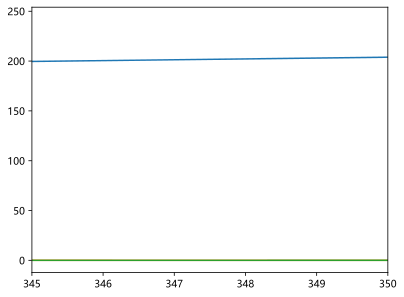

In [15]:
for i in [0,1,2]:
    plt.plot(results[i].expect[1])
plt.xlim(345,350)
# plt.ylim(0,0.01)

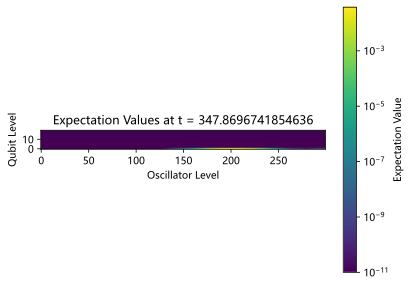

In [16]:
from CoupledQuantumSystems.visualization import *
plot_heatmap(results[0],347,system.product_to_dressed,max_ql,max_ol,LogNorm())

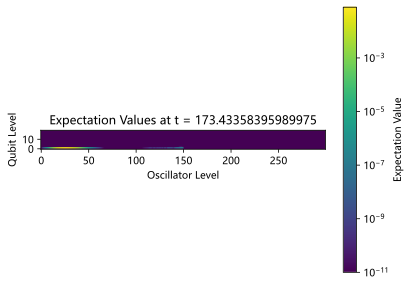

In [17]:
plot_heatmap(results[1],int(347/2),system.product_to_dressed,max_ql,max_ol,LogNorm())

In [20]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized

def convert_dressed_to_product_vectorized(system, states, products_to_keep, num_processes=None, update_products_to_keep=True):
    if update_products_to_keep:
        system.set_new_product_to_keep(products_to_keep)
        system.set_new_operators_after_setting_new_product_to_keep()

    if num_processes is None:
        num_processes = multiprocessing.cpu_count()

    # Multiprocessing, vectorized
    partial_function = partial(get_product_vectorized,
                               pad_back_custom=system.pad_back_function,
                               product_to_dressed=system.product_to_dressed,
                               sign_multiplier_vector=system.sign_multiplier_vector)

    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the iterator to show the progress
        product_states = list(tqdm(pool.imap(partial_function, states), total=len(states), desc="Processing States"))

    return product_states


for i, (result, products_to_keep) in enumerate(zip(results, list_of_products_to_keep)):
    result.states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
                                                                           states= result.states,
                                                                            products_to_keep = products_to_keep,
                                                                            num_processes = 14
                                                                                    )
with open('sesolve_small_dim_a015_tomo_product.pkl', 'wb') as f:
    pickle.dump(results,f)

Processing States: 100%|██████████| 400/400 [03:19<00:00,  2.01it/s]


In [5]:
with open('sesolve_small_dim_a015_tomo_product.pkl', 'rb') as f:
    results = pickle.load(f)

t loop: 100%|██████████| 400/400 [00:00<00:00, 458.62it/s]


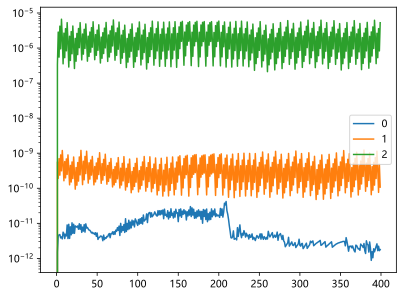

In [21]:
leakage_arr = np.zeros(shape=(3,len(tlist)))
for ql,result in zip([0,1,2],[results[0],results[1],results[2]]):
    initial_qbt_state = qutip.basis(max_ql,  ql)
    op = initial_qbt_state * initial_qbt_state.dag()
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = result.states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[ql,t_idx] = 1-qutip.expect(op, rho_qbt)

for ql in [0,1,2]:
    plt.plot(leakage_arr[ql],label=f'{ql}')
plt.legend()
plt.yscale('log')

In [6]:
def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


In [7]:
from scipy.optimize import minimize
infidelity = []
phase = []
original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(1,0)]]) + np.pi
original_phase = original_phase % (2*np.pi) 

for idx in tqdm(range(len(tlist)), desc='Processing'):
    dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 1,2) for result in results[1:]]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
    opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
    infidelity.append(opt_result.fun)
    phase.append(opt_result.x[0])
    

fig, axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(tlist,phase)
axes[0].set_title('phase correction')
axes[1].plot(tlist,infidelity)
axes[1].set_yscale('log')
axes[1].set_title('infidelity')


Processing:  23%|██▎       | 92/400 [00:04<00:16, 18.59it/s]


KeyboardInterrupt: 

In [6]:
# state_leak_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(0,0)])
state_0_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(1,0)])
state_1_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(2,0)])
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                    # state_leak_dressed,
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

# leakage_products_to_keep = [[ql, ol] for ql in range(10) for ol in range(max_ol) ]
computational_products_to_keep = [[ql, ol] for ql in range(10) for ol in range(150) ]
list_of_products_to_keep = [
    # leakage_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep
]


# list_of_systems = []
# list_of_kwargs = []
# for products_to_keep, y0 in zip(list_of_products_to_keep, initial_states):
#     system.set_new_product_to_keep(products_to_keep)
#     system.set_new_operators_after_setting_new_product_to_keep()
#     list_of_systems.append(deepcopy(system))
#     list_of_kwargs.append( {
#         'y0':system.truncate_function(y0) ,
#         'tlist':tlist,
#         'drive_terms':[DriveTerm( 
#                             driven_op= system.driven_operator,
#                             pulse_shape_func=square_pulse_with_rise_fall,
#                             pulse_shape_args={
#                                 'w_d': w_d ,
#                                 'amp': amp,
#                                 't_rise': 20,
#                                 't_square': tot_time
#                             })],
#         'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
#         # 'c_ops':[kappa *qutip.lindblad_dissipator(system.a_trunc) ]
#         })
    

# results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
#     list_of_systems,
#     list_of_kwargs,
#     post_processing = ['pad_back']
# )

# import pickle
# with open('sesolve_large_dim_a015_tomo.pkl', 'wb') as file:
#     pickle.dump(results, file)


In [3]:
import pickle
with open('sesolve_large_dim_a015_tomo.pkl', 'rb') as file:
    results = pickle.load(file)


In [9]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized

def convert_dressed_to_product_vectorized(system, states, products_to_keep, num_processes=None, update_products_to_keep=True):
    if update_products_to_keep:
        system.set_new_product_to_keep(products_to_keep)
        system.set_new_operators_after_setting_new_product_to_keep()

    if num_processes is None:
        num_processes = multiprocessing.cpu_count()

    # Multiprocessing, vectorized
    partial_function = partial(get_product_vectorized,
                               pad_back_custom=system.pad_back_function,
                               product_to_dressed=system.product_to_dressed,
                               sign_multiplier_vector=system.sign_multiplier_vector)

    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the iterator to show the progress
        product_states = list(tqdm(pool.imap(partial_function, states), total=len(states), desc="Processing States"))

    return product_states


# for i, (result, products_to_keep) in enumerate(zip(results, list_of_products_to_keep)):
#     result.states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
#                                                                            states= result.states,
#                                                                             products_to_keep = products_to_keep,
#                                                                             num_processes = 18
#                                                                                     )
# with open('sesolve_large_dim_a015_tomo_product.pkl', 'wb') as f:
#     pickle.dump(results,f)


for i, result, products_to_keep in zip([0,1,2,3,4,5][5:],results[5:], list_of_products_to_keep[5:]):
    states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
                                                                           states= result.states,
                                                                            products_to_keep = products_to_keep,
                                                                            num_processes = 14
                                                                                    )
    with open(f'sesolve_large_dim_a015_tomo_product_part{i}.pkl', 'wb') as f:
        pickle.dump(states_in_product_basis,f)

Processing States: 100%|██████████| 400/400 [03:40<00:00,  1.81it/s]


t loop: 100%|██████████| 400/400 [00:13<00:00, 29.21it/s]


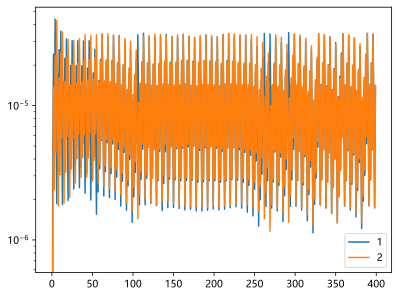

In [11]:
leakage_arr = np.zeros(shape=(2,len(tlist)))
for ql in [1,2]:
    initial_qbt_state = qutip.basis(max_ql,  ql)
    op = initial_qbt_state * initial_qbt_state.dag()
    with open(f'sesolve_large_dim_a015_tomo_product_part{ql-1}.pkl', 'rb') as f:
        states_in_product_basis = pickle.load(f)
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[ql-1,t_idx] = 1-qutip.expect(op, rho_qbt)

for ql in [1,2]:
    plt.plot(leakage_arr[ql-1],label=f'{ql}')
plt.legend()
plt.yscale('log')

In [4]:
for i, result in zip([0,1,2,3,4,5],results):
    with open(f'sesolve_large_dim_a015_tomo_product_part{i}.pkl', 'rb') as f:
        states_in_product_basis = pickle.load(f)
    result.states_in_product_basis = states_in_product_basis

In [5]:
def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


In [8]:
from scipy.optimize import minimize
infidelity = []
phase = []
original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(1,0)]]) + np.pi
original_phase = original_phase % (2*np.pi) 

for idx in tqdm(range(len(tlist)), desc='Processing'):
    dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 1,2) for result in results]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
    opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
    infidelity.append(opt_result.fun)
    phase.append(opt_result.x[0])

Processing: 100%|██████████| 400/400 [02:24<00:00,  2.78it/s]


Text(0.5, 1.0, 'infidelity')

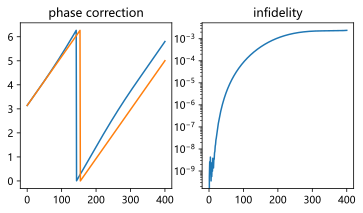

In [9]:
    
fig, axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(tlist,phase)
axes[0].plot(tlist,original_phase)

axes[0].set_title('phase correction')
axes[1].plot(tlist,infidelity)
axes[1].set_yscale('log')
axes[1].set_title('infidelity')

In [10]:
with open(f'sesolve_large_dim_a015_tomo_infidelity.pkl', 'wb') as f:
    pickle.dump(infidelity,f)

In [ ]:
leakage_arr = np.zeros(shape=(6,len(tlist)))
initial_qbt_state = qutip.basis(max_ql,  1)
op = initial_qbt_state * initial_qbt_state.dag()
for i in [0,1,2,3,4,5]:
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = results[i].states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[i,t_idx] = 1-qutip.expect(op, rho_qbt)

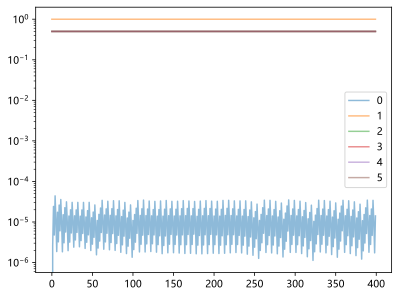

: 

In [14]:
for i in [0,1,2,3,4,5]:
    plt.plot(leakage_arr[i],label=f'{i}',alpha=0.5)
plt.legend()
plt.yscale('log')